In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn as sns
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
nltk.download('stopwords')
nltk.download('punkt')

import ast
from google.colab import drive
drive.mount('/content/drive')

from transformers import AutoTokenizer, TFAutoModel, TFAutoModelForMaskedLM

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q transformers==4.37.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 27.0 MB/s eta 0:00:00


In [ ]:
!pip install pydot

In [ ]:
file_path = '/content/drive/MyDrive/keybert/'
train_df = pd.read_csv(file_path + 'train_df_important.csv')
val_df = pd.read_csv(file_path + 'val_df_important.csv')
test_df = pd.read_csv(file_path + 'test_df_important.csv')

In [ ]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(32072, 8)
(4009, 8)
(4008, 8)


In [ ]:
train_df.head(1)

,title,abstract,subjareas,keywords,asjc,body_text,author_highlights,important_words
0,PEITC induces apoptosis of Human Brain Gliobla...,Glioblastoma is the most common and most aggre...,"['BIOC', 'NEUR']","['Apoptosis', 'Caspases', 'Glioblastoma', 'Mit...","['1307', '2804']",['Glioblastoma is the most common and most agg...,['We investigate the pro-apoptotic effects of ...,"[('glioblastoma', 0.7298), ('radiotherapy', 0...."


In [ ]:
val_df.head(1)

,title,abstract,subjareas,keywords,asjc,body_text,author_highlights,important_words
0,"Chemical profile, cytotoxic and antiparasitic ...",The aim of this study was carry out a phytoche...,['AGRI'],"['Antiepimastigote', 'Antipromastigote activit...",['1110'],['Infectious and parasitic diseases are still ...,['The fingerprint of phytocompounds identified...,"[('epidemiological', 0.5405), ('trypanosomiasi..."


In [ ]:
test_df.head(1)

,title,abstract,subjareas,keywords,asjc,body_text,author_highlights,important_words
0,Structure and content of phenolics in eggplant...,In the last years eggplant has received a grea...,['AGRI'],"['Anthocyanins', 'Chlorogenic acid', 'Delphini...",['1110'],"['Eggplant (also known as brinjal, aubergine, ...","['Eggplant is considered a functional food, be...","[('eggplant', 0.7497), ('eggplant', 0.6502), (..."


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32072 entries, 0 to 32071
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              32072 non-null  object
 1   abstract           31836 non-null  object
 2   subjareas          32072 non-null  object
 3   keywords           32072 non-null  object
 4   asjc               32072 non-null  object
 5   body_text          32072 non-null  object
 6   author_highlights  32072 non-null  object
 7   important_words    32072 non-null  object
dtypes: object(8)
memory usage: 2.0+ MB


In [ ]:
def safe_literal_eval(s):
    try:
        return ast.literal_eval(s)
    except ValueError:
        return s

def apply_safe_literal_eval_and_check(df, column_name):
    df[column_name] = df[column_name].apply(safe_literal_eval)
    not_converted = df[column_name].apply(lambda x: isinstance(x, str))
    if not_converted.any():
        print(f"Rows that were not converted in column '{column_name}':")
        print(df.loc[not_converted, column_name].head())

columns_to_convert = ['important_words', 'subjareas', 'author_highlights', 'asjc', 'body_text', 'keywords']

for column in columns_to_convert:
    apply_safe_literal_eval_and_check(train_df, column)
    apply_safe_literal_eval_and_check(val_df, column)
    apply_safe_literal_eval_and_check(test_df, column)

In [ ]:
label_counts = pd.Series([label for sublist in train_df['subjareas'] for label in sublist]).value_counts()
label_counts_df = label_counts.reset_index()
label_counts_df.columns = ['Subject Area', 'Frequency']

fig = px.bar(label_counts_df, x='Subject Area', y='Frequency', title='Frequency of Each Subject Area Label')
fig.show()


In [ ]:
train_df.head()

,title,abstract,subjareas,keywords,asjc,body_text,author_highlights,important_words
0,PEITC induces apoptosis of Human Brain Gliobla...,Glioblastoma is the most common and most aggre...,"[BIOC, NEUR]","[Apoptosis, Caspases, Glioblastoma, Mitochondr...","[1307, 2804]",[Glioblastoma is the most common and most aggr...,[We investigate the pro-apoptotic effects of P...,"[(glioblastoma, 0.7298), (radiotherapy, 0.4073..."
1,Multi-step biocatalytic strategies for chiral ...,Chiral amino alcohols are structural motifs pr...,"[BIOC, CENG, IMMU]","[Cascades, Chiral amino alcohols, Recycling sy...","[1303, 1305, 1502, 2402]",[Chiral amino alcohols are key functionalities...,[A double-recycling cascade for the synthesis ...,"[(sphingolipids, 0.5694), (biocatalytic, 0.665..."
2,Achieving respectable motherhood? Exploring th...,This paper explores the tension between post-f...,[SOCI],[],"[3303, 3304, 3312]","[As Jackson, Paechter, and Renold (2010) maint...",[Focus on women's agency in maternal choice-ma...,"[(discourse, 0.4245), (women, 0.4883), (femini..."
3,"Soft++, a multi-parametric non-saturating non-...",A key strategy to enable training of deep neur...,"[COMP, NEUR]","[Activation function, Convolutional neural net...","[1702, 1706, 2805]",[Deep learning has become extremely popular in...,[],"[(popular, 0.358), (neural, 0.443), (gpus, 0.4..."
4,Imaging ancient and mummified specimens: Dual-...,"In mummified animals and humans, soft tissues ...",[SOCI],"[Ancient Egypt, Animal mummies, Computed tomog...","[1204, 3302]","[A challenge in the field of paleoradiology, w...",[Soft tissues and bone can have similar densit...,"[(paleoradiology, 0.5741), (mummification, 0.5..."


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32072 entries, 0 to 32071
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              32072 non-null  object
 1   abstract           31836 non-null  object
 2   subjareas          32072 non-null  object
 3   keywords           32072 non-null  object
 4   asjc               32072 non-null  object
 5   body_text          32072 non-null  object
 6   author_highlights  32072 non-null  object
 7   important_words    32072 non-null  object
dtypes: object(8)
memory usage: 2.0+ MB


Step 2: Data Pre-processing

In [ ]:
def trim_text(text, word_limit):
    if isinstance(text, list):
        text = ' '.join(str(x) for x in text)
    if pd.isna(text):
        return ""
    words = text.split()[:word_limit]
    return ' '.join(words)



def add_additional_body_text(body_text, start_index, word_limit):
    if isinstance(body_text, list):
        body_text = ' '.join(body_text)
    words = body_text.split()[start_index:start_index+word_limit]
    return ' '.join(words)

def trim_important_words(important_words, word_limit):
    try:
        words_and_weights = ast.literal_eval(important_words)
        words = [word for word, weight in words_and_weights[:word_limit]]
        return ' '.join(words)
    except ValueError:
        return ""

def process_texts(df, abstract_column_name, body_text_column_name, title_column_name, important_words_column_name, word_limit_for_important_words):
    concatenated_texts = []
    for abstract, body, title, important_words in zip(df[abstract_column_name], df[body_text_column_name], df[title_column_name], df[important_words_column_name]):
        important_words_processed = trim_important_words(important_words, word_limit_for_important_words)
        initial_sequence = f"{trim_text(abstract, 200)} [SEP] {trim_text(body, 250)} [SEP] {trim_text(title, 50)} [SEP] {important_words_processed}"
        text_segments = [initial_sequence]
        additional_body_text = add_additional_body_text(body, 300, 500)
        if additional_body_text:
            text_segments.append(additional_body_text)
        second_additional_body_text = add_additional_body_text(body, 800, 500)
        if second_additional_body_text:
            text_segments.append(second_additional_body_text)
        concatenated_texts.append(text_segments)
    return concatenated_texts

def prepare_elsevier_data(train_df, val_df, test_df, abstract_column_name='abstract', body_text_column_name='body_text', title_column_name='title', label_column_name='subjareas', important_words_column_name='important_words', word_limit_for_important_words=10):
    mlb = MultiLabelBinarizer()
    all_labels = pd.concat([train_df[label_column_name], val_df[label_column_name], test_df[label_column_name]])
    mlb.fit(all_labels)

    train_labels = mlb.transform(train_df[label_column_name])
    val_labels = mlb.transform(val_df[label_column_name])
    test_labels = mlb.transform(test_df[label_column_name])

    concatenated_train_texts = process_texts(train_df, abstract_column_name, body_text_column_name, title_column_name, important_words_column_name, word_limit_for_important_words)
    concatenated_val_texts = process_texts(val_df, abstract_column_name, body_text_column_name, title_column_name, important_words_column_name, word_limit_for_important_words)
    concatenated_test_texts = process_texts(test_df, abstract_column_name, body_text_column_name, title_column_name, important_words_column_name, word_limit_for_important_words)

    return (concatenated_train_texts, train_labels, concatenated_val_texts, val_labels, concatenated_test_texts, test_labels, mlb.classes_)

concatenated_train_texts, train_labels, concatenated_val_texts, val_labels, concatenated_test_texts, test_labels, target_names = prepare_elsevier_data(train_df, val_df, test_df)


In [ ]:
print(train_labels[:2])
print(concatenated_train_texts[:2])
print(len(target_names))

[[0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]
[['Glioblastoma is the most common and most aggressive primary brain malignancy. The multimodality treatments for this tumor including surgery, radiotherapy, and chemotherapy, are still not completely satisfied. Phenethyl isothiocyanate (PEITC), one member of the isothiocyanate family, has been shown to induce apoptosis in many human cancer cells. In this study, we investigate the pro-apoptotic effects caused by PETIC in human brain glioblastoma multiforme GBM 8401 cells. In our data, PEITC induced the cell morphological changes and decreased the cell viability of GBM8401 cells in a dose- and time-dependent manner. Moreover, the analysis of cell cycle distribution detected by flow cytometry showed that PEITC induced significantly sub-G1 phase (apoptotic population) in GBM 8401 cells. In addition, PEITC promoted the production of reactive oxygen species (ROS) and increase in [Ca2+]I, but decreased the mitocho

In [ ]:
print(len(concatenated_train_texts))
print(len(concatenated_val_texts))

32072
4009


In [ ]:
# Convert validation labels to a NumPy array
npvalid_labels = np.asarray(val_labels)
nptrain_labels = np.asarray(train_labels)
nptest_labels = np.asarray(test_labels)


step 3: Classification with fine tuned BERT Model

In [ ]:
model_checkpoint = 'allenai/scibert_scivocab_cased'

scibert_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

scibert_model = TFAutoModel.from_pretrained(model_checkpoint, from_pt=True)

scibert_mlm = TFAutoModelForMaskedLM.from_pretrained(model_checkpoint, from_pt=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [ ]:
def tokenize_texts(text_segments_list, tokenizer, max_length=512):
    """
    Tokenizes a list of text segments using the provided tokenizer.

    Args:
        text_segments_list (list of list of str): Each inner list contains one or more text segments for a document.
        tokenizer: The tokenizer to use.
        max_length (int): The maximum token length for each segment.

    Returns:
        A list of tokenized and encoded text segments suitable for model input.
    """
    tokenized_outputs = []

    for text_segments in text_segments_list:
        document_encodings = [tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf') for text in text_segments]
        tokenized_outputs.append(document_encodings)

    return tokenized_outputs

train_encodings = tokenize_texts(concatenated_train_texts, scibert_tokenizer)
valid_encodings = tokenize_texts(concatenated_val_texts, scibert_tokenizer)
test_encodings = tokenize_texts(concatenated_test_texts, scibert_tokenizer)


In [ ]:
def print_encoding_shapes(encodings_list, encoding_type="Abstract"):
    """
    Prints the shapes of input_ids, token_type_ids, and attention_mask for given encodings.

    Since encodings are now in a list of lists of tensors format, we need to iterate through them.

    Args:
    - encodings_list: A list of lists of tokenized encodings from the BERT tokenizer.
    - encoding_type: A string indicating the type of encoding (e.g., "Abstract" or "Body").
    """
    print(f"\n{encoding_type} Texts Encodings Shapes:")

    for doc_idx, doc_encodings in enumerate(encodings_list):
        print(f"Document {doc_idx + 1}:")
        for seg_idx, seg_encodings in enumerate(doc_encodings):
            input_ids_shape = seg_encodings['input_ids'].shape
            token_type_ids_shape = seg_encodings['token_type_ids'].shape
            attention_mask_shape = seg_encodings['attention_mask'].shape

            print(f" Segment {seg_idx + 1}:")
            print(f"  Input IDs shape: {input_ids_shape}")
            print(f"  Token Type IDs shape: {token_type_ids_shape}")
            print(f"  Attention Mask shape: {attention_mask_shape}")

print_encoding_shapes(train_encodings, "Train")
print_encoding_shapes(valid_encodings, "Validation")
print_encoding_shapes(test_encodings, "Test")

Streaming output truncated to the last 5000 lines.
 Segment 3:
  Input IDs shape: (1, 512)
  Token Type IDs shape: (1, 512)
  Attention Mask shape: (1, 512)
Document 3621:
 Segment 1:
  Input IDs shape: (1, 512)
  Token Type IDs shape: (1, 512)
  Attention Mask shape: (1, 512)
 Segment 2:
  Input IDs shape: (1, 512)
  Token Type IDs shape: (1, 512)
  Attention Mask shape: (1, 512)
Document 3622:
 Segment 1:
  Input IDs shape: (1, 512)
  Token Type IDs shape: (1, 512)
  Attention Mask shape: (1, 512)
 Segment 2:
  Input IDs shape: (1, 512)
  Token Type IDs shape: (1, 512)
  Attention Mask shape: (1, 512)
 Segment 3:
  Input IDs shape: (1, 512)
  Token Type IDs shape: (1, 512)
  Attention Mask shape: (1, 512)
Document 3623:
 Segment 1:
  Input IDs shape: (1, 512)
  Token Type IDs shape: (1, 512)
  Attention Mask shape: (1, 512)
 Segment 2:
  Input IDs shape: (1, 512)
  Token Type IDs shape: (1, 512)
  Attention Mask shape: (1, 512)
 Segment 3:
  Input IDs shape: (1, 512)
  Token Type IDs

step 3: Set maximum dimension length based on the data

Step 4: Apply tokenization process to  Elsevier corpus. Tokenization converts your text data into a format that the BERT model can understand and process. It involves splitting the text into tokens (words or subwords), truncating sequences to the maximum length (max_length), and padding shorter sequences with zeros.

In [ ]:
import pandas as pd
import numpy as np

def compute_sample_weights(df, label_column):
    """
    Compute sample weights for multi-label classification.

    Parameters:
    - df: pandas DataFrame containing the training data
    - label_column: string name of the DataFrame column containing the labels lists

    Returns:
    - sample_weights: numpy array of sample weights where rows correspond to samples
    """
    label_freq = pd.Series([label for sublist in df[label_column] for label in sublist]).value_counts()

    label_weights = 1 / label_freq

    label_weights /= label_weights.sum()

    label_weight_map = label_weights.to_dict()

    sample_weights = []

    for labels in df[label_column]:
        sample_weight = sum([label_weight_map[label] for label in labels])
        sample_weights.append(sample_weight)

    return np.array(sample_weights)

sample_weights = compute_sample_weights(train_df, 'subjareas')


This model fine-tunes a pretrained SciBERT model for multi-label text classification, enriched with a CNN layer for enhanced feature extraction from concatenated embeddings of two input segments. It employs convolution and max-pooling followed by dense layers, and it outputs predictions for 18 classes using a sigmoid activation function. The model is compiled with the Adam optimizer and binary cross-entropy loss, targeting improved performance through the combined strengths of transformers and CNNs.




In [ ]:
def build_finetune_scibert_with_cnn_segments(pretrained_model_name_or_path='allenai/scibert_scivocab_cased', num_classes=18, hidden_size=[1024], dropout=0.1, learning_rate=0.00005, cnn_filters=64, kernel_size=5, pooling_size=2, from_pt=True):
    tf.keras.backend.clear_session()

    pretrained_LLM = TFAutoModel.from_pretrained(pretrained_model_name_or_path, from_pt=from_pt)
    pretrained_LLM.trainable = True

    input_ids_1 = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids_segment_1')
    attention_mask_1 = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask_segment_1')

    input_ids_2 = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids_segment_2')
    attention_mask_2 = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask_segment_2')

    input_ids_3 = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids_segment_3')
    attention_mask_3 = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask_segment_3')

    input_ids_4 = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids_segment_4')
    attention_mask_4 = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask_segment_4')

    cls_embeddings = []
    for input_ids, attention_mask in [(input_ids_1, attention_mask_1), (input_ids_2, attention_mask_2), (input_ids_3, attention_mask_3),  (input_ids_4, attention_mask_4)]:
        llm_out = pretrained_LLM({'input_ids': input_ids, 'attention_mask': attention_mask})
        cls_embedding = llm_out.last_hidden_state[:, 0, :]
        cls_embeddings.append(cls_embedding)

    combined_cls_embeddings = tf.keras.layers.Concatenate(axis=1)(cls_embeddings)

    combined_cls_embeddings_expanded = tf.expand_dims(combined_cls_embeddings, axis=-1)

    cnn_layer = tf.keras.layers.Conv1D(filters=cnn_filters, kernel_size=kernel_size, activation='relu')(combined_cls_embeddings_expanded)
    pooling_layer = tf.keras.layers.MaxPooling1D(pool_size=pooling_size)(cnn_layer)
    flattened_layer = tf.keras.layers.Flatten()(pooling_layer)

    hidden = flattened_layer
    for i, size in enumerate(hidden_size):
        hidden = tf.keras.layers.Dense(size, activation='relu', name=f'hidden_layer_{i}')(hidden)
        hidden = tf.keras.layers.Dropout(dropout)(hidden)

    output_classification = tf.keras.layers.Dense(num_classes, activation='sigmoid')(hidden)

    model_inputs = [input_ids_1, attention_mask_1, input_ids_2, attention_mask_2, input_ids_3, attention_mask_3, input_ids_4, attention_mask_4 ]
    classification_model = tf.keras.Model(inputs=model_inputs, outputs=[output_classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics=['accuracy'])

    return classification_model


In [ ]:
''''
import tensorflow as tf
from transformers import TFAutoModel

def build_finetune_scibert_with_cnn_and_attention(pretrained_model_name_or_path='allenai/scibert_scivocab_cased', num_classes=18, hidden_size=[1024], dropout=0.2, learning_rate=0.00005, cnn_filters=64, kernel_size=3, pooling_size=2, additional_cnn_layers=1, from_pt=True):
    tf.keras.backend.clear_session()

    # Load the pretrained model
    pretrained_LLM = TFAutoModel.from_pretrained(pretrained_model_name_or_path, from_pt=from_pt)
    pretrained_LLM.trainable = True

    # Define inputs
    input_ids_1 = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids_segment_1')
    attention_mask_1 = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask_segment_1')
    input_ids_2 = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids_segment_2')
    attention_mask_2 = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask_segment_2')

    cls_embeddings = []
    for input_ids, attention_mask in [(input_ids_1, attention_mask_1), (input_ids_2, attention_mask_2)]:
        llm_out = pretrained_LLM({'input_ids': input_ids, 'attention_mask': attention_mask})
        cls_embedding = llm_out.last_hidden_state[:, 0, :]
        cls_embeddings.append(cls_embedding)

    combined_cls_embeddings = tf.keras.layers.Concatenate(axis=1)(cls_embeddings)
    combined_cls_embeddings_expanded = tf.expand_dims(combined_cls_embeddings, axis=-1)

    # CNN Layer
    cnn_layer = tf.keras.layers.Conv1D(filters=cnn_filters, kernel_size=kernel_size, activation='relu')(combined_cls_embeddings_expanded)

    # Additional CNN Layers
    for _ in range(additional_cnn_layers):
        cnn_layer = tf.keras.layers.Conv1D(filters=cnn_filters, kernel_size=kernel_size, activation='relu')(cnn_layer)
        cnn_layer = tf.keras.layers.MaxPooling1D(pool_size=pooling_size)(cnn_layer)

    pooling_layer = tf.keras.layers.MaxPooling1D(pool_size=pooling_size)(cnn_layer)
    flattened_layer = tf.keras.layers.Flatten()(pooling_layer)

    # Attention mechanism
    attention_probs = tf.keras.layers.Dense(flattened_layer.shape[1], activation='softmax', name='attention_vec')(flattened_layer)
    attention_mul = tf.keras.layers.multiply([flattened_layer, attention_probs], name='attention_mul')

    hidden = attention_mul
    for i, size in enumerate(hidden_size):
        hidden = tf.keras.layers.Dense(size, activation='relu', name=f'hidden_layer_{i}')(hidden)
        hidden = tf.keras.layers.Dropout(dropout)(hidden)

    output_classification = tf.keras.layers.Dense(num_classes, activation='sigmoid')(hidden)

    model_inputs = [input_ids_1, attention_mask_1, input_ids_2, attention_mask_2]
    classification_model = tf.keras.Model(inputs=model_inputs, outputs=[output_classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics=['accuracy'])

    return classification_model

''''

In [ ]:
num_subject_areas = len(target_names)
num_subject_areas

18

In [ ]:
model_checkpoint = 'allenai/scibert_scivocab_cased'
num_subject_areas = 18
max_length = 500

cnn_filters = 64
kernel_size = 5
pooling_size = 2

scibert_model = build_finetune_scibert_with_cnn_segments(
    pretrained_model_name_or_path=model_checkpoint,
    num_classes=num_subject_areas,
    hidden_size=[1024],
    dropout=0.1,
    learning_rate=0.00005,
    cnn_filters=cnn_filters,
    kernel_size=kernel_size,
    pooling_size=pooling_size,
    from_pt=True
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [ ]:
scibert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_segment_1 (  [(None, None)]               0         []                            
 InputLayer)                                                                                      
                                                                                                  
 input_ids_segment_1 (Input  [(None, None)]               0         []                            
 Layer)                                                                                           
                                                                                                  
 attention_mask_segment_2 (  [(None, None)]               0         []                            
 InputLayer)                                                                                  

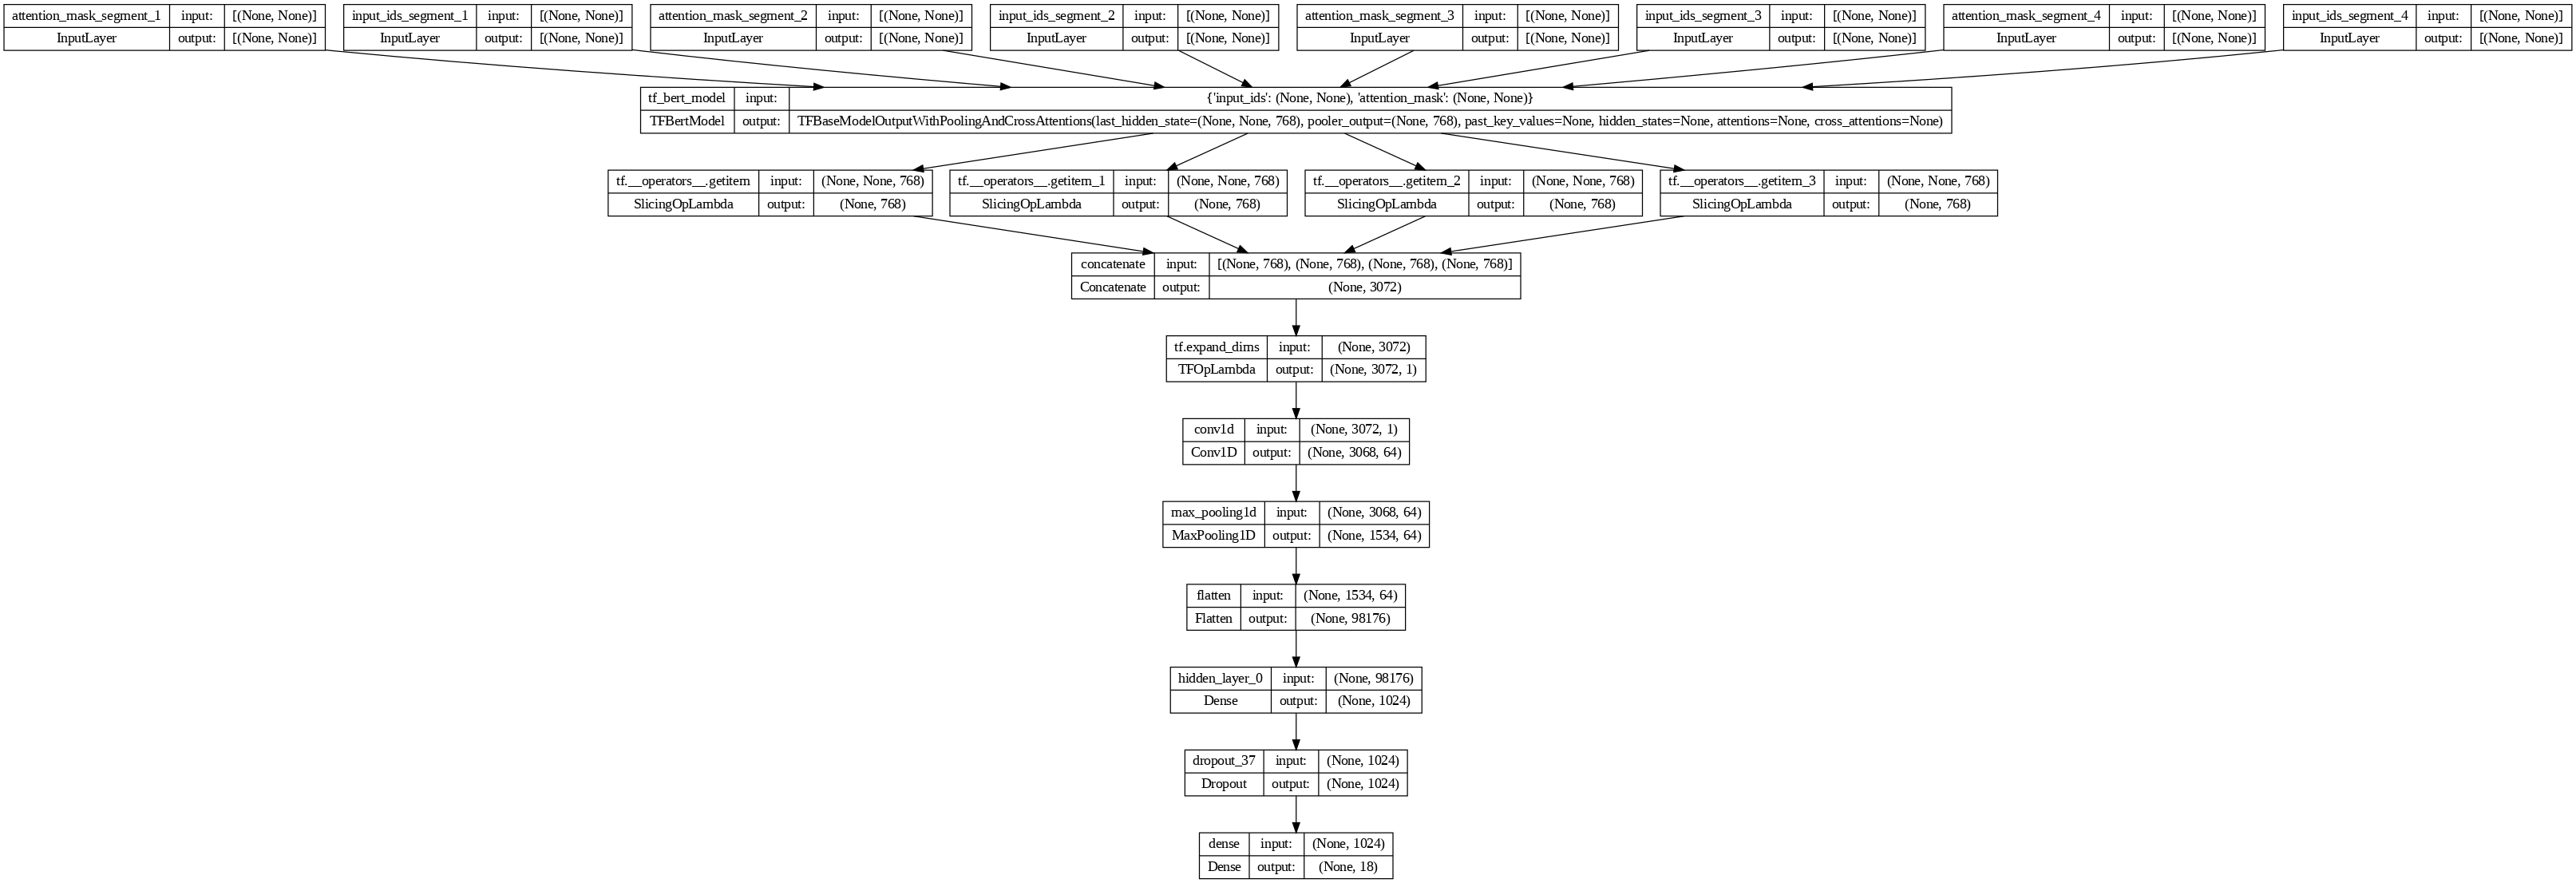

In [ ]:
keras.utils.plot_model(scibert_model, show_shapes=True, show_dtype=False, show_layer_names=True, dpi=90)

In [ ]:
#It takes 10 to 14 minutes to complete an epoch when using a GPU
# model_history = scibert_model.fit(
#     [train_encodings.input_ids, train_encodings.attention_mask],
#     train_labels,
#     validation_data=(
#         [valid_encodings.input_ids, valid_encodings.attention_mask],
#         val_labels
#     ),
#     batch_size=8,
#     epochs=2,
#     sample_weight=sample_weights
# )

In [ ]:
def restructure_encodings_for_training(tokenized_outputs):
    input_ids_segment_1, attention_masks_segment_1 = [], []
    input_ids_segment_2, attention_masks_segment_2 = [], []
    input_ids_segment_3, attention_masks_segment_3 = [], []
    input_ids_segment_4, attention_masks_segment_4 = [], []

    for doc_encodings in tokenized_outputs:
        segment_1 = doc_encodings[0]
        input_ids_segment_1.append(segment_1['input_ids'].numpy())
        attention_masks_segment_1.append(segment_1['attention_mask'].numpy())

        if len(doc_encodings) > 1:
            segment_2 = doc_encodings[1]
            input_ids_segment_2.append(segment_2['input_ids'].numpy())
            attention_masks_segment_2.append(segment_2['attention_mask'].numpy())
        else:
            input_ids_segment_2.append(segment_1['input_ids'].numpy())
            attention_masks_segment_2.append(segment_1['attention_mask'].numpy())

        if len(doc_encodings) > 2:
            segment_3 = doc_encodings[2]
            input_ids_segment_3.append(segment_3['input_ids'].numpy())
            attention_masks_segment_3.append(segment_3['attention_mask'].numpy())
        else:
            input_ids_segment_3.append(segment_1['input_ids'].numpy())
            attention_masks_segment_3.append(segment_1['attention_mask'].numpy())

        if len(doc_encodings) > 3:
            segment_4 = doc_encodings[3]
            input_ids_segment_4.append(segment_4['input_ids'].numpy())
            attention_masks_segment_4.append(segment_4['attention_mask'].numpy())
        else:
            input_ids_segment_4.append(segment_1['input_ids'].numpy())
            attention_masks_segment_4.append(segment_1['attention_mask'].numpy())

    input_ids_segment_1 = np.vstack(input_ids_segment_1)
    attention_masks_segment_1 = np.vstack(attention_masks_segment_1)
    input_ids_segment_2 = np.vstack(input_ids_segment_2)
    attention_masks_segment_2 = np.vstack(attention_masks_segment_2)
    input_ids_segment_3 = np.vstack(input_ids_segment_3)
    attention_masks_segment_3 = np.vstack(attention_masks_segment_3)
    input_ids_segment_4 = np.vstack(input_ids_segment_4)
    attention_masks_segment_4 = np.vstack(attention_masks_segment_4)

    return [input_ids_segment_1, attention_masks_segment_1, input_ids_segment_2, attention_masks_segment_2, input_ids_segment_3, attention_masks_segment_3, input_ids_segment_4, attention_masks_segment_4]

train_inputs = restructure_encodings_for_training(train_encodings)
valid_inputs = restructure_encodings_for_training(valid_encodings)
test_inputs = restructure_encodings_for_training(test_encodings)

model_history = scibert_model.fit(
    train_inputs,
    train_labels,
    validation_data=(valid_inputs, val_labels),
    batch_size=8,
    epochs=2,
    sample_weight=sample_weights
)


Epoch 1/2


4009/4009 [==============================] - 3577s 877ms/step - loss: 0.0150 - accuracy: 0.4800 - val_loss: 0.1521 - val_accuracy: 0.5630
Epoch 2/2
4009/4009 [==============================] - 3501s 873ms/step - loss: 0.0112 - accuracy: 0.5566 - val_loss: 0.1452 - val_accuracy: 0.5697


Validation Data Set Evaluation

In [ ]:
val_score = scibert_model.evaluate(
    valid_inputs,
    val_labels,
    batch_size=8
)
print('Val loss:', val_score[0])
print('Val accuracy:', val_score[1])


502/502 [==============================] - 141s 281ms/step - loss: 0.1452 - accuracy: 0.5697
Val loss: 0.14519144594669342
Val accuracy: 0.5697181224822998


In [ ]:
val_predictions = scibert_model.predict(
    valid_inputs,
    batch_size=8
)


502/502 [==============================] - 151s 278ms/step


              precision    recall  f1-score   support

        AGRI       0.68      0.83      0.75       421
        BIOC       0.70      0.67      0.69       680
        CENG       0.43      0.61      0.50       185
        CHEM       0.63      0.58      0.60       225
        COMP       0.52      0.43      0.47       168
        EART       0.67      0.76      0.71       217
        ENER       0.60      0.83      0.69       246
        ENGI       0.62      0.61      0.61       425
        ENVI       0.60      0.75      0.67       517
        IMMU       0.60      0.78      0.68       273
        MATE       0.79      0.64      0.71       343
        MEDI       0.78      0.73      0.76       851
        MULT       0.94      0.52      0.67       377
        NEUR       0.76      0.93      0.84       357
        PHAR       0.56      0.67      0.61       229
        PHYS       0.67      0.51      0.58       228
        PSYC       0.41      0.90      0.56       144
        SOCI       0.77    

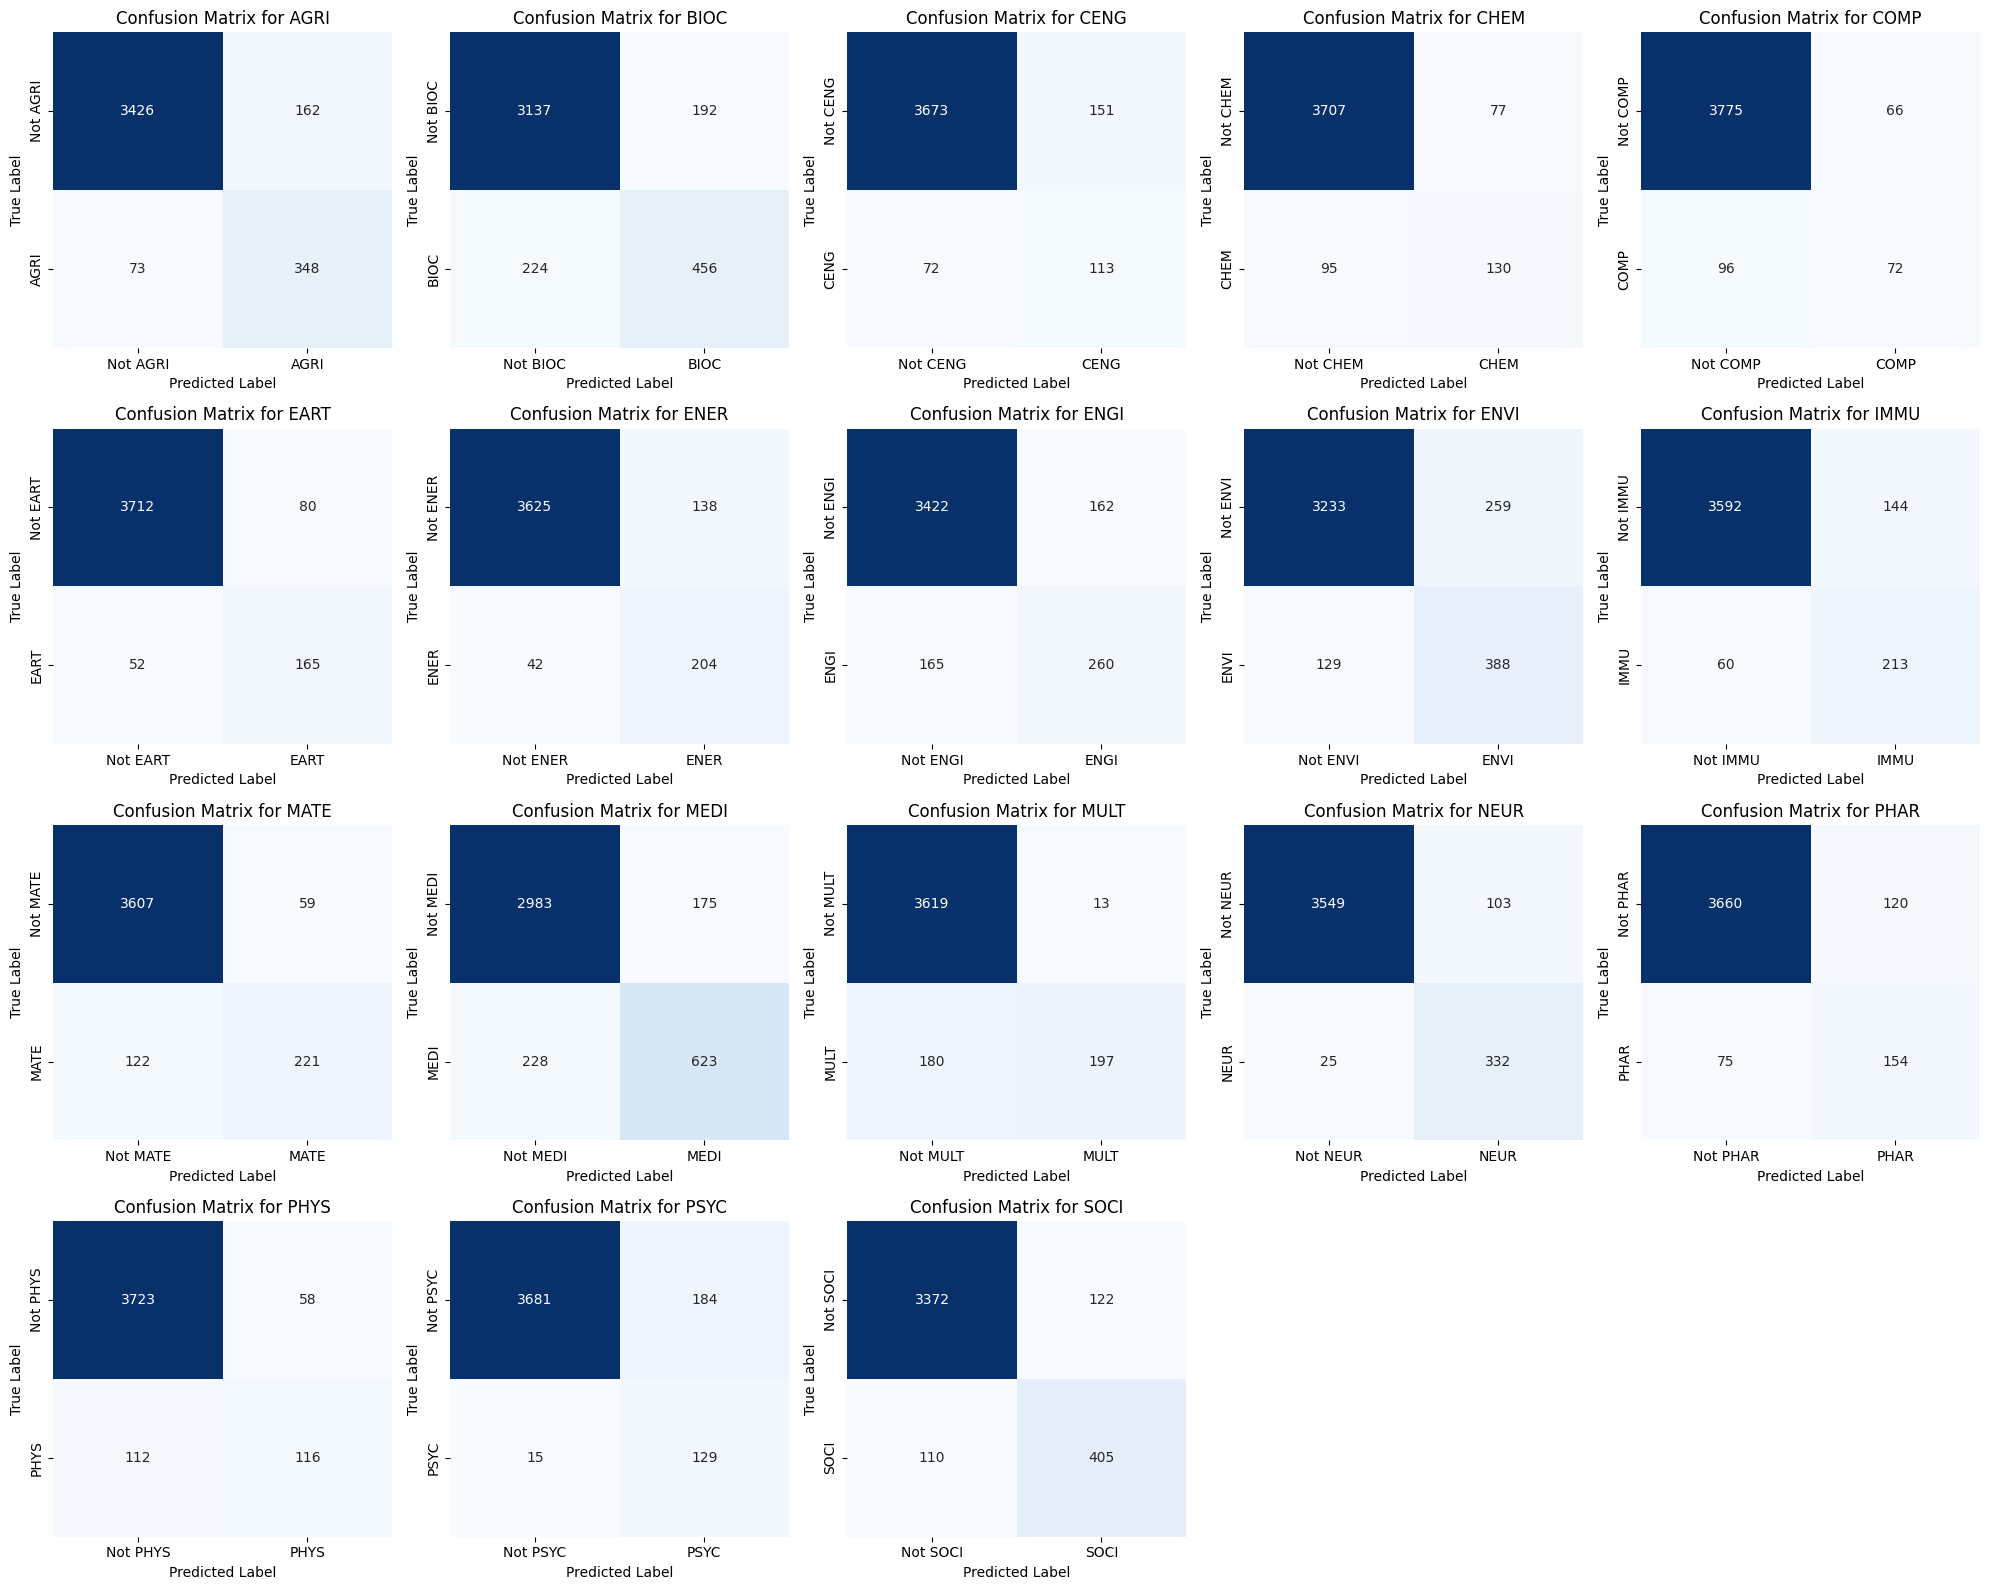

In [ ]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

def show_results(model, features, true_labels, classes, threshold=0.5):
    yhat_val = (val_predictions >= threshold).astype(int)

    print(classification_report(true_labels, yhat_val, target_names=classes, zero_division=1))

    confusion_matrices = multilabel_confusion_matrix(true_labels, yhat_val)

    n_classes = len(classes)
    n_cols = 5
    n_rows = int(np.ceil(n_classes / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))

    axes = axes.flatten()

    for i, matrix in enumerate(confusion_matrices):
        sns.heatmap(matrix,
                    annot=True,
                    fmt='d',
                    cmap='Blues',
                    cbar=False,
                    ax=axes[i])
        axes[i].set_title(f'Confusion Matrix for {classes[i]}')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
        axes[i].set_xticklabels(['Not '+classes[i], classes[i]])
        axes[i].set_yticklabels(['Not '+classes[i], classes[i]], va='center')

    for ax in axes[n_classes:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_results(scibert_model,
             valid_inputs,
             val_labels,
             target_names)


In [ ]:
test_score = scibert_model.evaluate(
    test_inputs,
    test_labels,
    batch_size=8
)
print('Val loss:', test_score[0])
print('Val accuracy:', test_score[1])


501/501 [==============================] - 141s 281ms/step - loss: 0.1400 - accuracy: 0.5821
Val loss: 0.13995936512947083
Val accuracy: 0.5820858478546143


In [ ]:
test_predictions = scibert_model.predict(
    test_inputs,
    batch_size=8
)


501/501 [==============================] - 140s 279ms/step


              precision    recall  f1-score   support

        AGRI       0.70      0.83      0.76       413
        BIOC       0.72      0.69      0.70       653
        CENG       0.46      0.62      0.53       189
        CHEM       0.63      0.54      0.58       248
        COMP       0.57      0.46      0.51       157
        EART       0.66      0.79      0.72       217
        ENER       0.60      0.78      0.68       235
        ENGI       0.66      0.64      0.65       444
        ENVI       0.59      0.70      0.64       512
        IMMU       0.53      0.77      0.63       238
        MATE       0.83      0.67      0.74       331
        MEDI       0.79      0.76      0.77       851
        MULT       0.97      0.60      0.74       467
        NEUR       0.81      0.92      0.86       394
        PHAR       0.61      0.62      0.61       219
        PHYS       0.58      0.45      0.51       203
        PSYC       0.37      0.88      0.52       120
        SOCI       0.73    

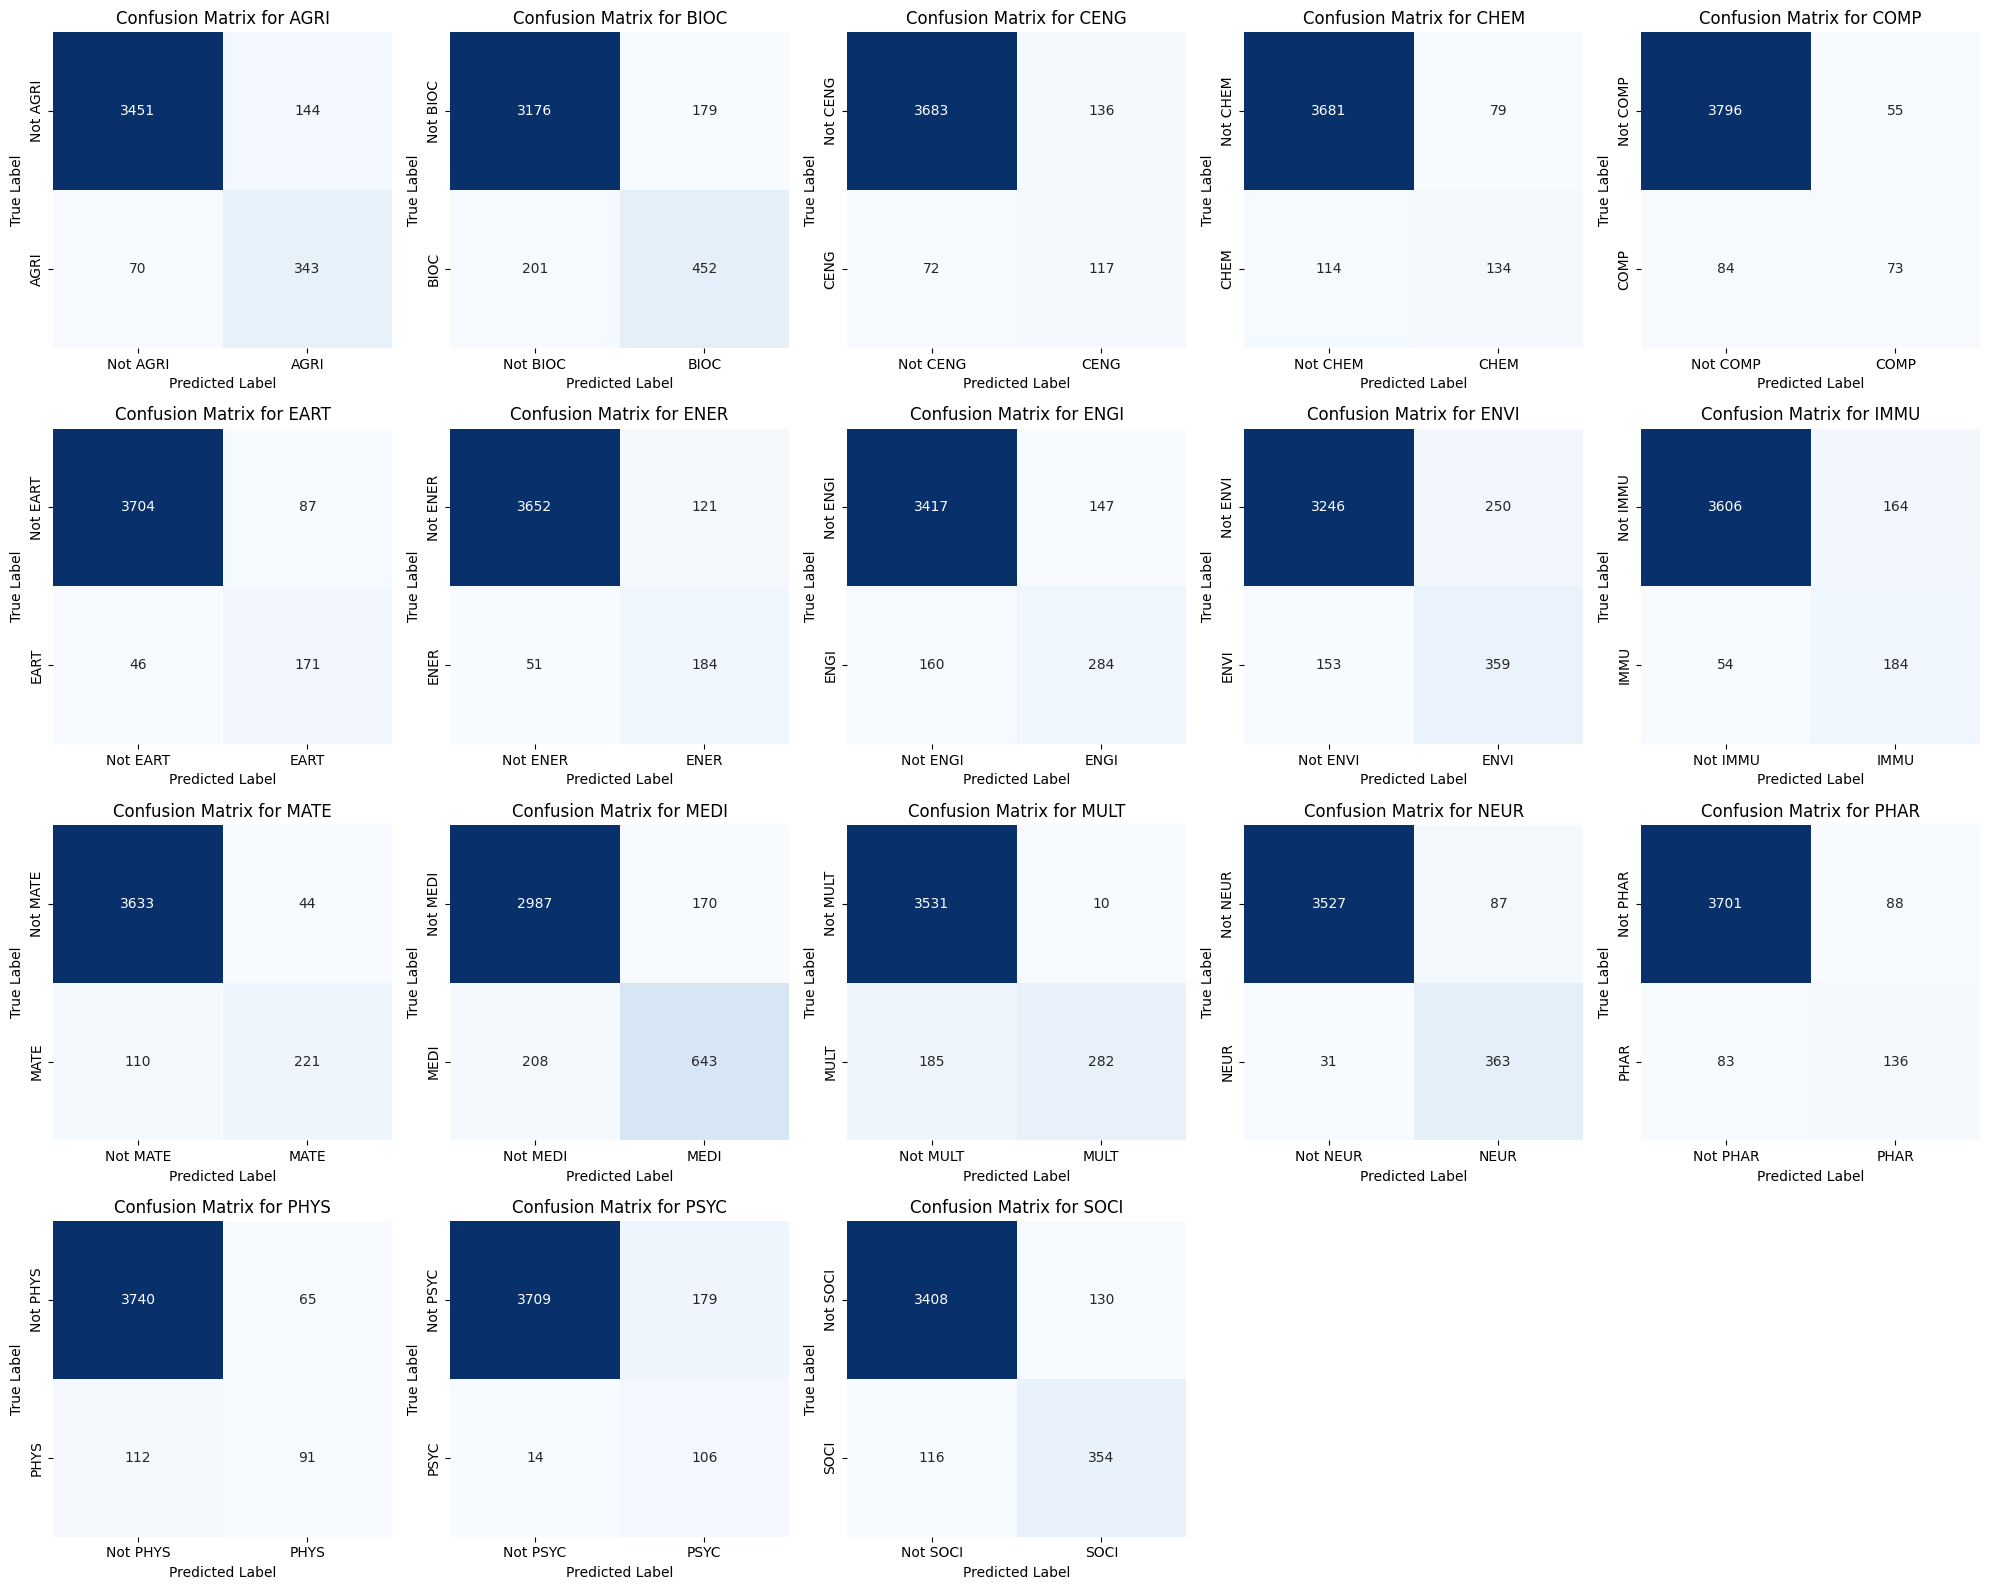

In [ ]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

def show_results(model, features, true_labels, classes, threshold=0.5):
    yhat_test = (test_predictions >= threshold).astype(int)

    print(classification_report(true_labels, yhat_test, target_names=classes, zero_division=1))

    confusion_matrices = multilabel_confusion_matrix(true_labels, yhat_test)

    n_classes = len(classes)
    n_cols = 5
    n_rows = int(np.ceil(n_classes / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))

    axes = axes.flatten()

    for i, matrix in enumerate(confusion_matrices):
        sns.heatmap(matrix,
                    annot=True,
                    fmt='d',
                    cmap='Blues',
                    cbar=False,
                    ax=axes[i])
        axes[i].set_title(f'Confusion Matrix for {classes[i]}')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
        axes[i].set_xticklabels(['Not '+classes[i], classes[i]])
        axes[i].set_yticklabels(['Not '+classes[i], classes[i]], va='center')

    for ax in axes[n_classes:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_results(scibert_model,
             test_inputs,
             test_labels,
             target_names)


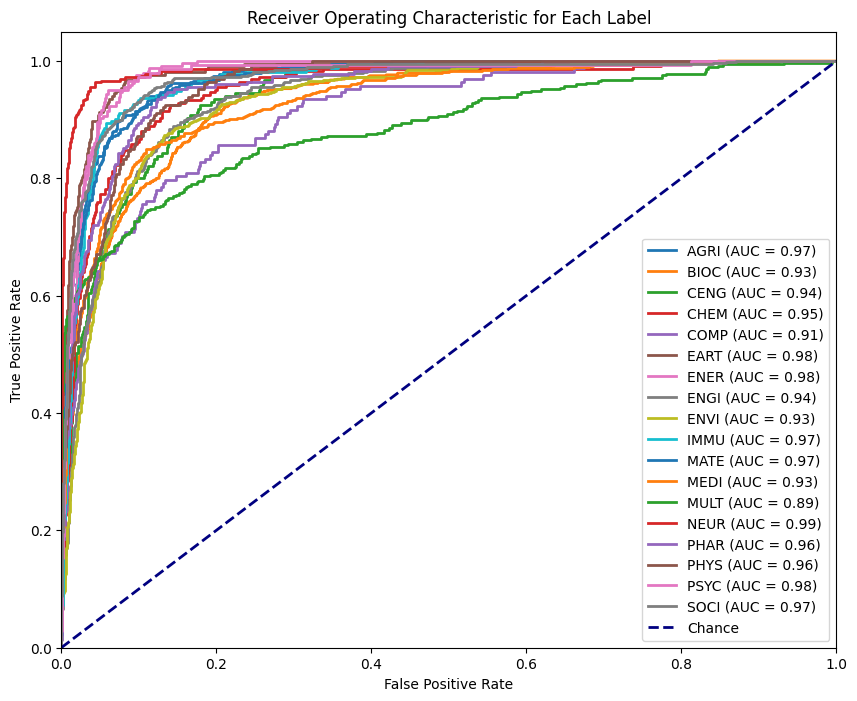

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_multilabel_roc(true_labels, predictions, target_names):
    """
    Function to plot the ROC curves for each label in multi-label classification.

    Parameters:
    - true_labels: Array-like of shape (n_samples, n_labels), ground truth label indicators.
    - predictions: Array-like of shape (n_samples, n_labels), prediction probabilities or decision function.
    - target_names: List of strings of shape (n_labels,), names of each of the labels.

    """
    n_labels = true_labels.shape[1]

    fig, ax = plt.subplots(figsize=(10, 8))

    for i in range(n_labels):
        fpr, tpr, _ = roc_curve(true_labels[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=2, label=f'{target_names[i]} (AUC = {roc_auc:.2f})')

    # Plot chance line
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')

    # Customize the plot
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic for Each Label')
    ax.legend(loc="lower right")

    # Show the plot
    plt.show()

plot_multilabel_roc(val_labels, val_predictions, target_names)


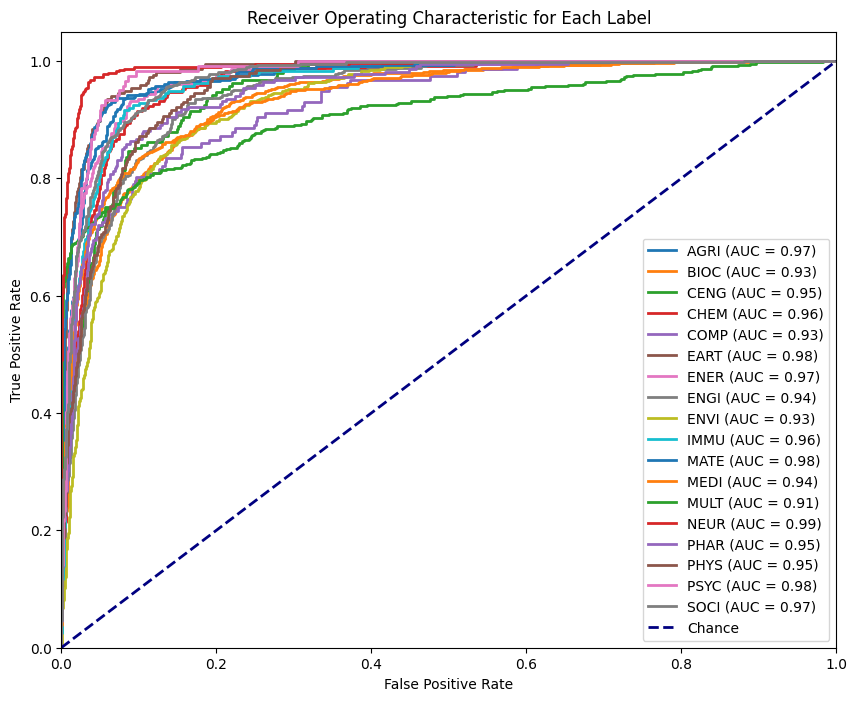

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_multilabel_roc(true_labels, predictions, target_names):
    """
    Function to plot the ROC curves for each label in multi-label classification.

    Parameters:
    - true_labels: Array-like of shape (n_samples, n_labels), ground truth label indicators.
    - predictions: Array-like of shape (n_samples, n_labels), prediction probabilities or decision function.
    - target_names: List of strings of shape (n_labels,), names of each of the labels.

    """
    n_labels = true_labels.shape[1]

    fig, ax = plt.subplots(figsize=(10, 8))

    for i in range(n_labels):
        fpr, tpr, _ = roc_curve(true_labels[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=2, label=f'{target_names[i]} (AUC = {roc_auc:.2f})')

    # Plot chance line
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')

    # Customize the plot
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic for Each Label')
    ax.legend(loc="lower right")

    # Show the plot
    plt.show()

plot_multilabel_roc(test_labels, test_predictions, target_names)


In [ ]:
!pip install google-auth

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

def save_predictions_to_csv(test_predictions, test_texts, test_df, target_names, result_path, threshold=0.5):
    """
    Process model predictions and save a CSV file with abstracts, true labels, predicted labels,
    the most probable predicted label, and its probability.

    Args:
        test_predictions (np.array): The predictions from the model, assumed to be probabilities.
        test_texts (list or np.array): The texts that were input to the model for prediction.
        test_df (pd.DataFrame): The original DataFrame containing the true labels.
        target_names (list): List of target class names corresponding to indices in model outputs.
        result_path (str, optional): Path to save the resulting CSV file. Defaults to './'.
        threshold (float, optional): Probability threshold to consider a prediction as positive. Defaults to 0.5.
    """
    predicted_labels = []
    max_probs = []
    max_labels = []

    for probs in test_predictions:
        labels = [target_names[idx] for idx, p in enumerate(probs) if p >= threshold]
        predicted_labels.append(labels)

        # Identify the max probability and corresponding label
        max_idx = np.argmax(probs)
        max_prob = probs[max_idx]
        max_label = target_names[max_idx]

        max_probs.append(max_prob)
        if labels:
            max_labels.append(max_label)
        else:
            max_probs[-1] = 0  # Reset max_prob if no labels meet the threshold
            max_labels.append("No Label")

    # Preparing the DataFrame
    result_df = pd.DataFrame({
        'abstract': test_texts,
        'true_label': test_df['subjareas'],
        'pred_label': predicted_labels,
        'max_pred_label': max_labels,
        'max_prediction_probability': max_probs
    })

    result_df['pred_label'] = result_df['pred_label'].apply(lambda x: ', '.join(x) if x else 'No Label')

    # Saving the results
    result_df.to_csv(result_path + 'scibert_cnn_part5.csv', index=False)

    return result_df

result_path = '/content/drive/MyDrive/'
save_predictions_to_csv(test_predictions, concatenated_test_texts, test_df, target_names, result_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,abstract,true_label,pred_label,max_pred_label,max_prediction_probability
0,[In the last years eggplant has received a gre...,[AGRI],AGRI,AGRI,0.966869
1,[Nitazoxanide is a thiazolide compound that wa...,"[IMMU, PHAR]","IMMU, PHAR",IMMU,0.893080
2,[Aims: To use a mouse model of imiquimod-induc...,[MULT],IMMU,IMMU,0.558758
3,[This paper presents an inter-comparison of th...,"[EART, ENVI]","ENVI, SOCI",ENVI,0.909445
4,[Compared with conventional household one/two ...,"[COMP, ENGI, SOCI]","ENGI, MEDI, SOCI",SOCI,0.956111
...,...,...,...,...,...
4003,[Osteopontin (OPN) is a multifunctional protei...,"[AGRI, IMMU]","AGRI, CHEM",AGRI,0.938048
4004,[The Witwatersrand Basin Goldfields (WBG) have...,[AGRI],"AGRI, ENVI",AGRI,0.887493
4005,[The concept of social licence to operate (SLO...,"[ENER, SOCI]",SOCI,SOCI,0.833259
4006,[Hydrogen sulfide (H 2 S) gas sensors in the f...,[MATE],"ENGI, MATE, PHYS",PHYS,0.530421
